In [2]:
import os
import rasterio
import numpy as np
from rasterio.warp import reproject, Resampling
from pystac_client import Client
from shapely.geometry import Point
from pyproj import Transformer

# --- CONFIGURATION ---
STAC_URL = "https://earth-search.aws.element84.com/v1"
COLLECTION = "sentinel-2-l2a"
CHIP_SIZE = 512
PIXEL_SIZE = 10 
NDVI_THRESHOLD = 0.6  # Values > 0.6 are considered "High Vegetation" (Forest)

def normalize_for_display(band_data):
    """
    Normalizes raw Sentinel-2 data (0-10000) to 0-255 for standard RGB viewing.
    Clips bright values at 3000 (0.3 reflectance) to make image visible.
    """
    normalized = np.clip(band_data / 3000.0, 0, 1) 
    return (normalized * 255).astype(np.uint8)

def get_aligned_chips(lat, lon, date_range, mask_path, output_dir):
    
    # 1. SETUP: Connect to Cloud API
    print(f"Searching for scene at {lat}, {lon}...")
    catalog = Client.open(STAC_URL)
    point = Point(lon, lat)
    
    # FIX: Removed 'sortby' parameter to prevent API Error.
    # We now just filter for low clouds and sort manually in Python.
    search = catalog.search(
        collections=[COLLECTION], 
        intersects=point, 
        datetime=date_range,
        query={"eo:cloud_cover": {"lt": 5}} # Still filter on server side
    )
    
    items = list(search.items())
    if not items: 
        raise ValueError("No clear scene found. Try increasing date range or cloud threshold.")
    
    # --- CLIENT-SIDE SORTING (Robust Fix) ---
    # Sort the downloaded list by cloud cover (lowest first)
    items.sort(key=lambda x: x.properties.get("eo:cloud_cover", 100))
    
    item = items[0]
    print(f"Found Scene: {item.id}") 
    print(f"   Date: {item.datetime}")
    print(f"   Cloud Cover: {item.properties['eo:cloud_cover']}%")
    
    # 2. DEFINE GRID (512x512 Window)
    with rasterio.open(item.assets["red"].href) as src:
        utm_crs = src.crs
        transformer = Transformer.from_crs("EPSG:4326", utm_crs, always_xy=True)
        cx, cy = transformer.transform(lon, lat)
        
        half_w = (CHIP_SIZE * PIXEL_SIZE) / 2
        minx, maxx = cx - half_w, cx + half_w
        miny, maxy = cy - half_w, cy + half_w
        
        dst_transform = rasterio.Affine(PIXEL_SIZE, 0, minx, 0, -PIXEL_SIZE, maxy)

    # 3. STREAM DATA (RGB + NIR)
    band_map = {"R": "red", "G": "green", "B": "blue", "N": "nir"}
    data_cache = {}
    
    print("Streaming bands...")
    for b_name, asset_key in band_map.items():
        url = item.assets[asset_key].href
        with rasterio.open(url) as src:
            arr = np.zeros((CHIP_SIZE, CHIP_SIZE), dtype=np.float32)
            reproject(
                source=rasterio.band(src, 1),
                destination=arr,
                dst_transform=dst_transform, dst_crs=utm_crs,
                src_transform=src.transform, src_crs=src.crs,
                resampling=Resampling.bilinear
            )
            data_cache[b_name] = arr

    # 4. PROCESS: Create Stacks & INDICES
    stack_4band = np.stack([data_cache["R"], data_cache["G"], data_cache["B"], data_cache["N"]])
    
    rgb_stack = np.stack([
        normalize_for_display(data_cache["R"]),
        normalize_for_display(data_cache["G"]),
        normalize_for_display(data_cache["B"])
    ])

    # --- NEW: Calculate NDVI Mask ---
    # Formula: (NIR - Red) / (NIR + Red)
    # We use np.divide with 'where' to safely handle division by zero (e.g., water/shadows)
    nir = data_cache["N"]
    red = data_cache["R"]
    denominator = nir + red
    
    ndvi = np.divide(
        (nir - red), 
        denominator, 
        out=np.zeros_like(nir), 
        where=denominator != 0
    )
    
    # Create Binary Mask based on Threshold
    # True if NDVI > 0.6 (Forest), False otherwise
    ndvi_binary_mask = (ndvi > NDVI_THRESHOLD).astype(np.uint8)

    # 5. PROCESS: Crop Mask to Match
    with rasterio.open(mask_path) as src_mask:
        mask_chip = np.zeros((CHIP_SIZE, CHIP_SIZE), dtype=np.uint8)
        reproject(
            source=rasterio.band(src_mask, 1),
            destination=mask_chip,
            dst_transform=dst_transform, dst_crs=utm_crs,
            src_transform=src_mask.transform, src_crs=src_mask.crs,
            resampling=Resampling.nearest 
        )

    # 6. SAVE OUTPUTS
    os.makedirs(output_dir, exist_ok=True)
    base_name = f"{lat}_{lon}"
    
    meta = {
        'driver': 'GTiff', 'width': CHIP_SIZE, 'height': CHIP_SIZE,
        'crs': utm_crs, 'transform': dst_transform
    }

    # Save 4-Band
    meta_4b = meta.copy()
    meta_4b.update({'count': 4, 'dtype': 'float32'})
    with rasterio.open(os.path.join(output_dir, f"Sentinel4B_{base_name}.tif"), 'w', **meta_4b) as dst:
        dst.write(stack_4band)

    # Save RGB
    meta_rgb = meta.copy()
    meta_rgb.update({'count': 3, 'dtype': 'uint8'})
    with rasterio.open(os.path.join(output_dir, f"RGB_{base_name}.tif"), 'w', **meta_rgb) as dst:
        dst.write(rgb_stack)

    # --- NEW: Save NDVI Binary Mask ---
    meta_ndvi = meta.copy()
    meta_ndvi.update({'count': 1, 'dtype': 'uint8'}) # Now saved as Uint8 (0 or 1)
    with rasterio.open(os.path.join(output_dir, f"NDVI_Mask_{base_name}.tif"), 'w', **meta_ndvi) as dst:
        dst.write(ndvi_binary_mask, 1)

    # Save Mask
    meta_mask = meta.copy()
    meta_mask.update({'count': 1, 'dtype': 'uint8'})
    with rasterio.open(os.path.join(output_dir, f"Mask_{base_name}.tif"), 'w', **meta_mask) as dst:
        dst.write(mask_chip, 1)

    print(f"Saved 4 files to {output_dir}")
    return rgb_stack, mask_chip, ndvi_binary_mask

In [ ]:
output_dir = "./data/chile_gfc_data"
granule = "40S_080W"
DENSITY_THRESHOLD = 0.005  # Adjust based on your visual preference from Insight B
RECENCY_THRESHOLD_YEAR = 0

mask_path = os.path.join(output_dir, f"{granule}_filtered_segmentation_mask_hard_{str(DENSITY_THRESHOLD).replace(".","")}_{RECENCY_THRESHOLD_YEAR}.tif")
first_path = os.path.join(output_dir, f"Hansen_GFC-2024-v1.12_first_{granule}.tif")
last_path = os.path.join(output_dir, f"Hansen_GFC-2024-v1.12_last_{granule}.tif")

rgb_chip, mask_chip, ndvi_mask_chip = get_aligned_chips(
    lat= -41.32, 
    lon=-72.55, 
    date_range="2018-01-01/2018-03-01", 
    mask_path=mask_path, 
    output_dir="/home/dhuencho/dev_py/0001_start_pytorch/src/UCL_AI4SD/CW2/data/chile_gfc_data/generated_chips_nd"
)

Searching for scene at -41.32, -72.55...
Found Scene: S2A_18GYV_20180124_1_L2A
   Date: 2018-01-24 14:54:13.370000+00:00
   Cloud Cover: 0.075721%
Streaming bands...
Saved 4 files to /home/dhuencho/dev_py/0001_start_pytorch/src/UCL_AI4SD/CW2/data/chile_gfc_data/generated_chips_nd


(array([[[ 22,  17,  16, ...,  40,  34,  33],
         [ 24,  17,  14, ...,  45,  44,  46],
         [ 23,  20,  18, ...,  44,  48,  50],
         ...,
         [122, 115,  71, ...,  15,  16,  17],
         [ 96,  92,  51, ...,  16,  15,  16],
         [ 56,  56,  36, ...,  15,  12,  15]],
 
        [[ 33,  25,  21, ...,  44,  36,  36],
         [ 34,  24,  21, ...,  48,  46,  47],
         [ 33,  27,  26, ...,  48,  51,  53],
         ...,
         [104,  99,  65, ...,  29,  29,  32],
         [ 84,  83,  51, ...,  28,  25,  29],
         [ 55,  55,  40, ...,  24,  19,  27]],
 
        [[ 17,  12,  12, ...,  27,  22,  22],
         [ 18,  12,  11, ...,  31,  30,  32],
         [ 17,  14,  13, ...,  30,  33,  35],
         ...,
         [ 77,  72,  47, ...,  12,  12,  13],
         [ 59,  56,  33, ...,  13,  13,  13],
         [ 35,  35,  23, ...,  11,   9,  11]]],
       shape=(3, 512, 512), dtype=uint8),
 array([[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1,

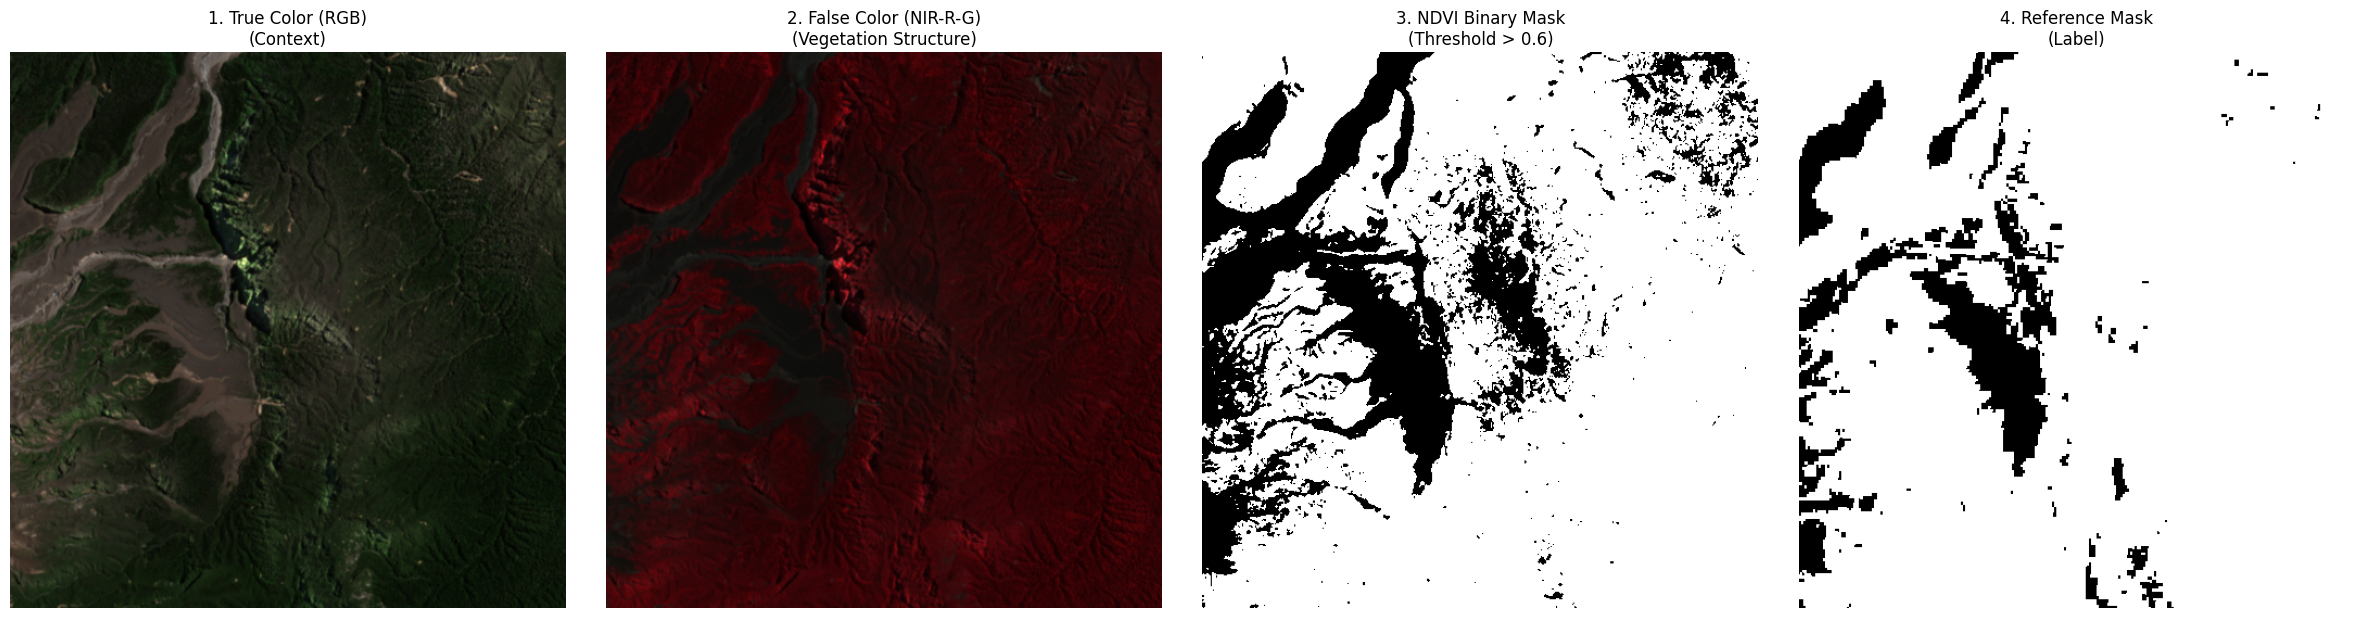

In [4]:
import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt

def normalize(array):
    """Normalizes float data (0-1 range) for display."""
    array_min, array_max = array.min(), array.max()
    # Avoid division by zero
    if array_max == array_min:
        return np.zeros_like(array)
    return (array - array_min) / (array_max - array_min)

def plot_saved_chips(lat, lon, output_dir):
    """
    Loads and plots the 4 saved files: RGB, False Color, Mask, and NDVI Binary Mask.
    """
    base_name = f"{lat}_{lon}"
    
    # 1. Define Paths (Updated for NDVI_Mask)
    path_rgb = os.path.join(output_dir, f"RGB_{base_name}.tif")
    path_4band = os.path.join(output_dir, f"Sentinel4B_{base_name}.tif")
    path_mask = os.path.join(output_dir, f"Mask_{base_name}.tif")
    path_ndvi_mask = os.path.join(output_dir, f"NDVI_Mask_{base_name}.tif") # Updated filename
    
    # Check if files exist
    for p in [path_rgb, path_4band, path_mask, path_ndvi_mask]:
        if not os.path.exists(p):
            print(f"Error: File not found: {p}")
            return

    # 2. Load Images
    # A. RGB (Uint8)
    with rasterio.open(path_rgb) as src:
        img_rgb = src.read().transpose(1, 2, 0)

    # B. 4-Band (Float32) -> False Color Composite (NIR, Red, Green)
    with rasterio.open(path_4band) as src:
        nir = src.read(4)
        red = src.read(1)
        green = src.read(2)
        img_false_color = np.dstack((nir, red, green))
        img_false_color = normalize(img_false_color)

    # C. Reference Mask (Uint8)
    with rasterio.open(path_mask) as src:
        img_mask = src.read(1)

    # D. NDVI Binary Mask (Uint8)
    with rasterio.open(path_ndvi_mask) as src:
        img_ndvi_mask = src.read(1)

    # 3. Plotting (1 Row, 4 Columns)
    fig, ax = plt.subplots(1, 4, figsize=(24, 6))
    
    # Plot 1: True Color
    ax[0].imshow(img_rgb)
    ax[0].set_title("1. True Color (RGB)\n(Context)")
    ax[0].axis('off')
    
    # Plot 2: False Color
    ax[1].imshow(img_false_color)
    ax[1].set_title("2. False Color (NIR-R-G)\n(Vegetation Structure)")
    ax[1].axis('off')
    
    # Plot 3: NDVI Binary Mask
    # Display as Binary: Black (0) / White (1)
    ax[2].imshow(img_ndvi_mask, cmap='gray', vmin=0, vmax=1)
    ax[2].set_title("3. NDVI Binary Mask\n(Threshold > 0.6)")
    ax[2].axis('off')
    
    # Plot 4: Reference Mask
    ax[3].imshow(img_mask, cmap='gray', vmin=0, vmax=1)
    ax[3].set_title("4. Reference Mask\n(Label)")
    ax[3].axis('off')
    
    plt.tight_layout()
    plt.show()

# --- USAGE ---
plot_saved_chips(-41.32, -72.55, "./data/chile_gfc_data/generated_chips_nd")

In [ ]:
import rasterio
import numpy as np
import pandas as pd
from scipy.ndimage import uniform_filter
from skimage.feature import peak_local_max

output_dir = "./data/chile_gfc_data"
granule = "40S_080W"
DENSITY_THRESHOLD = 0.005  # Adjust based on your visual preference from Insight B
RECENCY_THRESHOLD_YEAR = 0

mask_path = os.path.join(output_dir, f"{granule}_filtered_segmentation_mask_hard_{str(DENSITY_THRESHOLD).replace(".","")}_{RECENCY_THRESHOLD_YEAR}.tif")
first_path = os.path.join(output_dir, f"Hansen_GFC-2024-v1.12_first_{granule}.tif")
last_path = os.path.join(output_dir, f"Hansen_GFC-2024-v1.12_last_{granule}.tif")

def find_sparse_zois(mask_path, chip_size=512, num_locations=10, min_distance_pixels=512):
    """
    Scans the entire mask to find the top 'num_locations' with the most deforestation.
    Enforces 'min_distance_pixels' between them to ensure variety.
    """
    print(f"Scanning {mask_path} for top {num_locations} hotspots...")
    
    # 1. Load Data (Downsampled for speed)
    # We read at 1/10th resolution. This is enough to find "hot regions".
    decimation = 10
    
    with rasterio.open(mask_path) as src:
        # Read low-res overview
        H, W = src.height, src.width
        # Use 'out_shape' to read a thumbnail version efficiently
        mask_small = src.read(
            1, 
            out_shape=(H // decimation, W // decimation),
            resampling=rasterio.enums.Resampling.bilinear
        )
        transform = src.transform
        crs = src.crs

    print(f"   Analysis Grid: {mask_small.shape}")

    # 2. Generate Density Score Map
    # We want to know: "If I place a chip here, how many '1's are inside?"
    # A uniform filter computes the local mean. 
    # Scaled chip size: If chip is 512px, in 1/10th scale it's ~51px.
    scaled_size = int(chip_size / decimation)
    
    # This creates a "heatmap" where bright pixels = dense deforestation zones
    score_map = uniform_filter(mask_small.astype(float), size=scaled_size)

    # 3. Find Sparse Peaks
    # peak_local_max finds local maxima and ensures they are 'min_distance' apart
    scaled_dist = int(min_distance_pixels / decimation)
    
    coordinates = peak_local_max(
        score_map, 
        min_distance=scaled_dist, 
        threshold_abs=0.01, # Ignore areas with almost 0 deforestation
        num_peaks=num_locations
    )

    # 4. Convert back to Real World Coordinates (Lat/Lon)
    results = []
    
    print(f"\n--- Top {len(coordinates)} Zones Found ---")
    for i, (py_small, px_small) in enumerate(coordinates):
        # Convert small pixel -> large pixel
        px_large = px_small * decimation
        py_large = py_small * decimation
        
        # Get Lat/Lon using the original file transform
        lon, lat = rasterio.transform.xy(transform, py_large, px_large, offset='center')
        
        # Get the relative "score" (density)
        score = score_map[py_small, px_small]
        
        results.append({
            "rank": i+1,
            "lat": lat,
            "lon": lon,
            "density_score": score
        })
        print(f"   Rank {i+1}: Lat {lat:.4f}, Lon {lon:.4f} (Score: {score:.4f})")

    return pd.DataFrame(results)

# --- USAGE ---
# mask_file = "path/to/your/filtered_mask.tif"

# # Find 10 zones, ensuring they are at least 1000 pixels apart (approx 10km)
df_zoi = find_sparse_zois(mask_path, chip_size=512, num_locations=10, min_distance_pixels=1000)

# # Iterate and Download
output_folder = "./data/chile_gfc_data/generated_chips"

for idx, row in df_zoi.iterrows():
    print(f"\nProcessing ZOI #{row['rank']}...")
    try:
        get_aligned_chips(row['lat'], row['lon'], "2023-01-01/2023-12-31", mask_path, output_folder)
    except Exception as e:
        print(f"Skipping: {e}")

Found 51 files. Parsing coordinates...
Found 51 files. Parsing coordinates...

--- DataFrame Preview ---
                                        filename   latitude  longitude
0                   Sentinel4B_-40.86_-72.71.tif -40.860000 -72.710000
1           Sentinel4B_-41.092625_-72.087375.tif -41.092625 -72.087375
2           Sentinel4B_-37.285125_-72.937375.tif -37.285125 -72.937375
3  Sentinel4B_-38.242625000000004_-72.914875.tif -38.242625 -72.914875
4  Sentinel4B_-39.492625000000004_-73.069875.tif -39.492625 -73.069875
Loading background map from web...


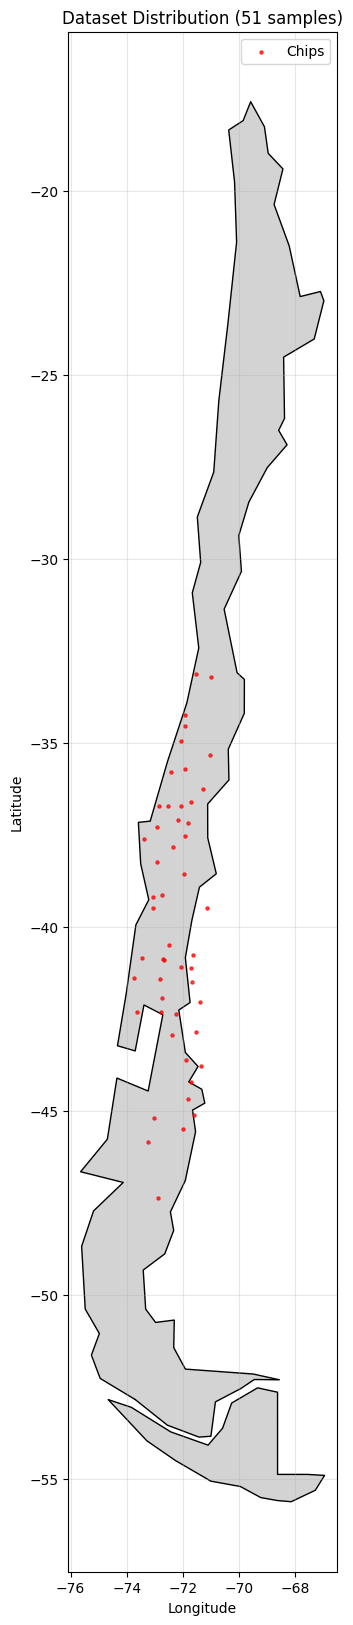

In [10]:
import os
import glob
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from shapely.geometry import Point

def create_geodataframe_from_files(folder_path, file_pattern="RGB"):
    """
    Scans a folder for files, parses lat/lon from filenames, 
    and returns a GeoDataFrame.
    
    Assumes filename format: "RGB_{lat}_{lon}.tif"
    Example: "RGB_-40.86_-72.71.tif"
    """

    file_path_pattern=f"{file_pattern}_*.tif"
    files = glob.glob(os.path.join(folder_path, file_path_pattern))
    
    data = []
    print(f"Found {len(files)} files. Parsing coordinates...")
    
    for file_path in files:
        filename = os.path.basename(file_path)
        
        try:
            # 1. Strip Prefix/Suffix
            # "RGB_-40.86_-72.71.tif" -> "-40.86_-72.71"
            clean_name = filename.replace(f"{file_pattern}_", "").replace(".tif", "")
            
            # 2. Split by Underscore
            # "-40.86_-72.71" -> ["-40.86", "-72.71"]
            parts = clean_name.split("_")
            
            if len(parts) >= 2:
                lat = float(parts[0])
                lon = float(parts[1])
                
                data.append({
                    "filename": filename,
                    "path": file_path,
                    "latitude": lat,
                    "longitude": lon
                })
        except Exception as e:
            print(f"Skipping {filename}: {e}")

    # 3. Create Pandas DataFrame
    df = pd.DataFrame(data)
    
    if df.empty:
        raise ValueError("No valid coordinates found!")

    # 4. Convert to GeoDataFrame (Geometric Points)
    gdf = gpd.GeoDataFrame(
        df, 
        geometry=gpd.points_from_xy(df.longitude, df.latitude),
        crs="EPSG:4326" # WGS84 (Lat/Lon standard)
    )
    
    return gdf

def plot_static_map(gdf):
    """
    Plots a static matplotlib map with Chile as background.
    """
    print("Loading background map from web...")
    
    # --- FIX: Load directly from URL (GeoPandas 1.0+ compatible) ---
    # This URL points to the standard 1:110m country boundaries
    world_url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
    world = gpd.read_file(world_url)
    
    # Filter for Chile
    # Note: 'NAME' is usually the column name in the raw shapefile (uppercase)
    # We try both 'name' and 'NAME' to be safe
    if 'NAME' in world.columns:
        chile = world[world['NAME'] == "Chile"]
    else:
        chile = world[world['name'] == "Chile"]
    
    # Setup Plot
    fig, ax = plt.subplots(figsize=(10, 20)) # Tall figure for Chile
    
    # 1. Plot Base Map (Chile)
    # If the map didn't load or Chile isn't found, this might be empty
    if not chile.empty:
        chile.plot(ax=ax, color='lightgrey', edgecolor='black')
    else:
        print("Warning: Could not isolate Chile from the map. Plotting all points anyway.")
    
    # 2. Plot Your Points
    # 'zorder=5' ensures points stay on TOP of the map
    gdf.plot(ax=ax, color='red', markersize=20, marker='.', alpha=0.7, label='Chips', zorder=5)
    
    # Styling
    plt.title(f"Dataset Distribution ({len(gdf)} samples)")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.show()

def plot_interactive_map(gdf, save_html="chile_chips_map.html"):
    """
    Creates an interactive HTML map (Folium) you can zoom/pan.
    """
    # Center map on the average location of your points
    center_lat = gdf.latitude.mean()
    center_lon = gdf.longitude.mean()
    
    m = folium.Map(location=[center_lat, center_lon], zoom_start=6)
    
    # Add points
    for idx, row in gdf.iterrows():
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=3,
            color='red',
            fill=True,
            fill_color='red',
            popup=row['filename'] # Clicking a dot shows the filename
        ).add_to(m)
        
    m.save(save_html)
    print(f"Interactive map saved to: {save_html}")
    return m

# --- USAGE ---
# Replace with your actual folder path
folder_path = "./data/chile_gfc_data/generated_chips"

# 1. Create DataFrame
gdf_chips = create_geodataframe_from_files(folder_path, file_pattern="Sentinel4B")
gdf_masks_chips = create_geodataframe_from_files(folder_path, file_pattern="NDVI_Mask")

# 2. Show DataFrame Head (Preview)
print("\n--- DataFrame Preview ---")
print(gdf_chips[['filename', 'latitude', 'longitude']].head())

# 3. Plot Static Map
plot_static_map(gdf_chips)

# 4. Create Interactive Map (Check your folder for the .html file!)
# map_obj = plot_interactive_map(gdf_chips)

In [23]:
import numpy as np

# 1. Define the specific (Lat, Lon) pairs you want to REMOVE
points_to_remove = [
    (-45.105125, -71.614875),
    (-45.847625, -73.262375),
    (-45.195125, -73.032375),
    (-41.092625, -72.087375),
    (-42.035125, -71.404875)
]

# 2. Create a "Keep" mask (Start with all True)
mask_keep = np.ones(len(gdf_chips), dtype=bool)
mask_keep_mask = np.ones(len(gdf_masks_chips), dtype=bool)

# 3. Iterate through bad points and update the mask
# We verify if BOTH lat and lon match (using isclose for safety)
for bad_lat, bad_lon in points_to_remove:
    # Check if lat matches AND lon matches
    is_bad_point = (
        np.isclose(gdf_chips['latitude'], bad_lat, atol=1e-5) & 
        np.isclose(gdf_chips['longitude'], bad_lon, atol=1e-5)
    )

    is_bad_point_mask = (
        np.isclose(gdf_masks_chips['latitude'], bad_lat, atol=1e-5) & 
        np.isclose(gdf_masks_chips['longitude'], bad_lon, atol=1e-5)
    )
    
    # If it's a bad point, we mark it False (don't keep)
    mask_keep = mask_keep & (~is_bad_point)
    mask_keep_mask = mask_keep_mask & (~is_bad_point_mask)

# 4. Apply the filter
gdf_clean = gdf_chips[mask_keep].copy().sort_values(by=['latitude', 'longitude']).reset_index(drop=True).reset_index(drop=False)
gdf_masks_clean = gdf_masks_chips[mask_keep_mask].copy().sort_values(by=['latitude', 'longitude']).reset_index(drop=True).reset_index(drop=False)

print(f"Original size: {len(gdf_chips)}")
print(f"Cleaned size:  {len(gdf_clean)}")
print(f"Removed {len(gdf_chips) - len(gdf_clean)} points.")

Original size: 51
Cleaned size:  46
Removed 5 points.


In [24]:
print(gdf_masks_clean[['latitude', 'longitude']].head())
print(gdf_clean[['latitude', 'longitude']].head())

    latitude  longitude
0 -47.370125 -72.884875
1 -45.490125 -72.014875
2 -44.660125 -71.812375
3 -44.215125 -71.719875
4 -43.772625 -71.364875
    latitude  longitude
0 -47.370125 -72.884875
1 -45.490125 -72.014875
2 -44.660125 -71.812375
3 -44.215125 -71.719875
4 -43.772625 -71.364875


In [25]:
import fiona
import geopandas as gpd

# 1. Enable KML Driver
# By default, some versions of Fiona disable KML. We force it on.
fiona.supported_drivers['KML'] = 'rw'

def save_to_kml(gdf, output_path):
    """
    Saves a GeoDataFrame to KML format for Google Earth.
    """
    print(f"Saving {len(gdf)} points to {output_path}...")
    
    # 2. Ensure CRS is WGS84 (Lat/Lon)
    # Google Earth ONLY understands EPSG:4326
    if gdf.crs != "EPSG:4326":
        print("Reprojecting to EPSG:4326...")
        gdf = gdf.to_crs("EPSG:4326")
        
    # 3. Select only useful columns
    # KMLs get messy if you keep complex columns like 'path'
    # We keep 'filename' as the label
    if 'index' in gdf.columns:
        output_gdf = gdf[['index', 'geometry']]
    else:
        output_gdf = gdf[['geometry']]

    # 4. Save
    output_gdf.to_file(output_path, driver='KML')
    print("Success! You can now open this file in Google Earth.")

# --- USAGE ---
# Assuming 'gdf_clean' is your filtered dataframe from the previous step
save_to_kml(gdf_clean, "Chile_Deforestation_Chips.kml")

Saving 46 points to Chile_Deforestation_Chips.kml...
Success! You can now open this file in Google Earth.


In [26]:
gdf_clean

,index,filename,path,latitude,longitude,geometry
0,0,Sentinel4B_-47.370125_-72.884875.tif,./data/chile_gfc_data/generated_chips/Sentinel...,-47.370125,-72.884875,POINT (-72.88488 -47.37012)
1,1,Sentinel4B_-45.490125_-72.014875.tif,./data/chile_gfc_data/generated_chips/Sentinel...,-45.490125,-72.014875,POINT (-72.01488 -45.49012)
2,2,Sentinel4B_-44.660125_-71.812375.tif,./data/chile_gfc_data/generated_chips/Sentinel...,-44.660125,-71.812375,POINT (-71.81238 -44.66012)
3,3,Sentinel4B_-44.215125_-71.719875.tif,./data/chile_gfc_data/generated_chips/Sentinel...,-44.215125,-71.719875,POINT (-71.71988 -44.21512)
4,4,Sentinel4B_-43.772625_-71.364875.tif,./data/chile_gfc_data/generated_chips/Sentinel...,-43.772625,-71.364875,POINT (-71.36488 -43.77262)
5,5,Sentinel4B_-43.625125_-71.884875.tif,./data/chile_gfc_data/generated_chips/Sentinel...,-43.625125,-71.884875,POINT (-71.88488 -43.62512)
6,6,Sentinel4B_-42.942625_-72.397375.tif,./data/chile_gfc_data/generated_chips/Sentinel...,-42.942625,-72.397375,POINT (-72.39738 -42.94262)
7,7,Sentinel4B_-42.845125_-71.552375.tif,./data/chile_gfc_data/generated_chips/Sentinel...,-42.845125,-71.552375,POINT (-71.55238 -42.84512)
8,8,Sentinel4B_-42.372625_-72.262375.tif,./data/chile_gfc_data/generated_chips/Sentinel...,-42.372625,-72.262375,POINT (-72.26238 -42.37262)
9,9,Sentinel4B_-42.297625_-72.784875.tif,./data/chile_gfc_data/generated_chips/Sentinel...,-42.297625,-72.784875,POINT (-72.78488 -42.29762)
